# Proyek Klasifikasi Gambar: MACAM MACAM SAMPAH
- **Nama:** DHAVA ADE PRATAMA
- **Email:** dhavaaadepratama23@gmail.com
- **ID Dicoding:** DHAVA ADE PRATAMA

## Import Semua Packages/Library yang Digunakan

In [1]:
import pandas as pd
import os
import kagglehub
import matplotlib.pyplot as plt
from PIL import Image
import random
from shutil import copyfile
import seaborn as sns

In [2]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise


In [52]:
#libraries untuk modeling
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import keras
from tensorflow.keras import models, layers
from keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16

### Data Loading

In [4]:
from google.colab import files
uploaded = files.upload() # Assign the results of files.upload() to the variable 'uploaded'

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [5]:
!kaggle datasets download -d farzadnekouei/trash-type-image-dataset

Dataset URL: https://www.kaggle.com/datasets/farzadnekouei/trash-type-image-dataset
License(s): unknown
 81% 33.0M/40.9M [00:00<00:00, 102MB/s] 
100% 40.9M/40.9M [00:00<00:00, 107MB/s]


In [6]:
from zipfile import ZipFile
file_name = "trash-type-image-dataset.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


## Data Preparation

In [41]:
def split_data(source_dir, train_dir, val_dir, test_dir, train_size=0.70, val_size=0.20, test_size=0.10):

    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for class_name in os.listdir(source_dir):
        source_class_dir = os.path.join(source_dir, class_name)
        if os.path.isdir(source_class_dir):
            train_class_dir = os.path.join(train_dir, class_name)
            val_class_dir = os.path.join(val_dir, class_name)
            test_class_dir = os.path.join(test_dir, class_name)

            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(val_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)

            images = [f for f in os.listdir(source_class_dir) if os.path.isfile(os.path.join(source_class_dir, f))]
            random.shuffle(images)
            num_images = len(images)
            num_train = int(num_images * train_size)
            num_val = int(num_images * val_size)

            train_images = images[:num_train]
            val_images = images[num_train:num_train + num_val]
            test_images = images[num_train + num_val:]

            for image in train_images:
                source_path = os.path.join(source_class_dir, image)
                destination_path = os.path.join(train_class_dir, image)
                copyfile(source_path, destination_path)

            for image in val_images:
                source_path = os.path.join(source_class_dir, image)
                destination_path = os.path.join(val_class_dir, image)
                copyfile(source_path, destination_path)

            for image in test_images:
                source_path = os.path.join(source_class_dir, image)
                destination_path = os.path.join(test_class_dir, image)
                copyfile(source_path, destination_path)

In [8]:
source_directory = "/content/TrashType_Image_Dataset"
training_directory = "/content/train"
validation_directory = "/content/val"
testing_directory = "/content/test"

split_data(source_directory, training_directory, validation_directory, testing_directory)

In [9]:
train_dir = "train"
test_dir = "test"
val_dir = "val"

print("Training set:", os.listdir(train_dir))
print("Testing set:", os.listdir(test_dir))
print("Validation set:", os.listdir(val_dir))

Training set: ['trash', 'metal', 'plastic', 'paper', 'cardboard', 'glass']
Testing set: ['trash', 'metal', 'plastic', 'paper', 'cardboard', 'glass']
Validation set: ['trash', 'metal', 'plastic', 'paper', 'cardboard', 'glass']


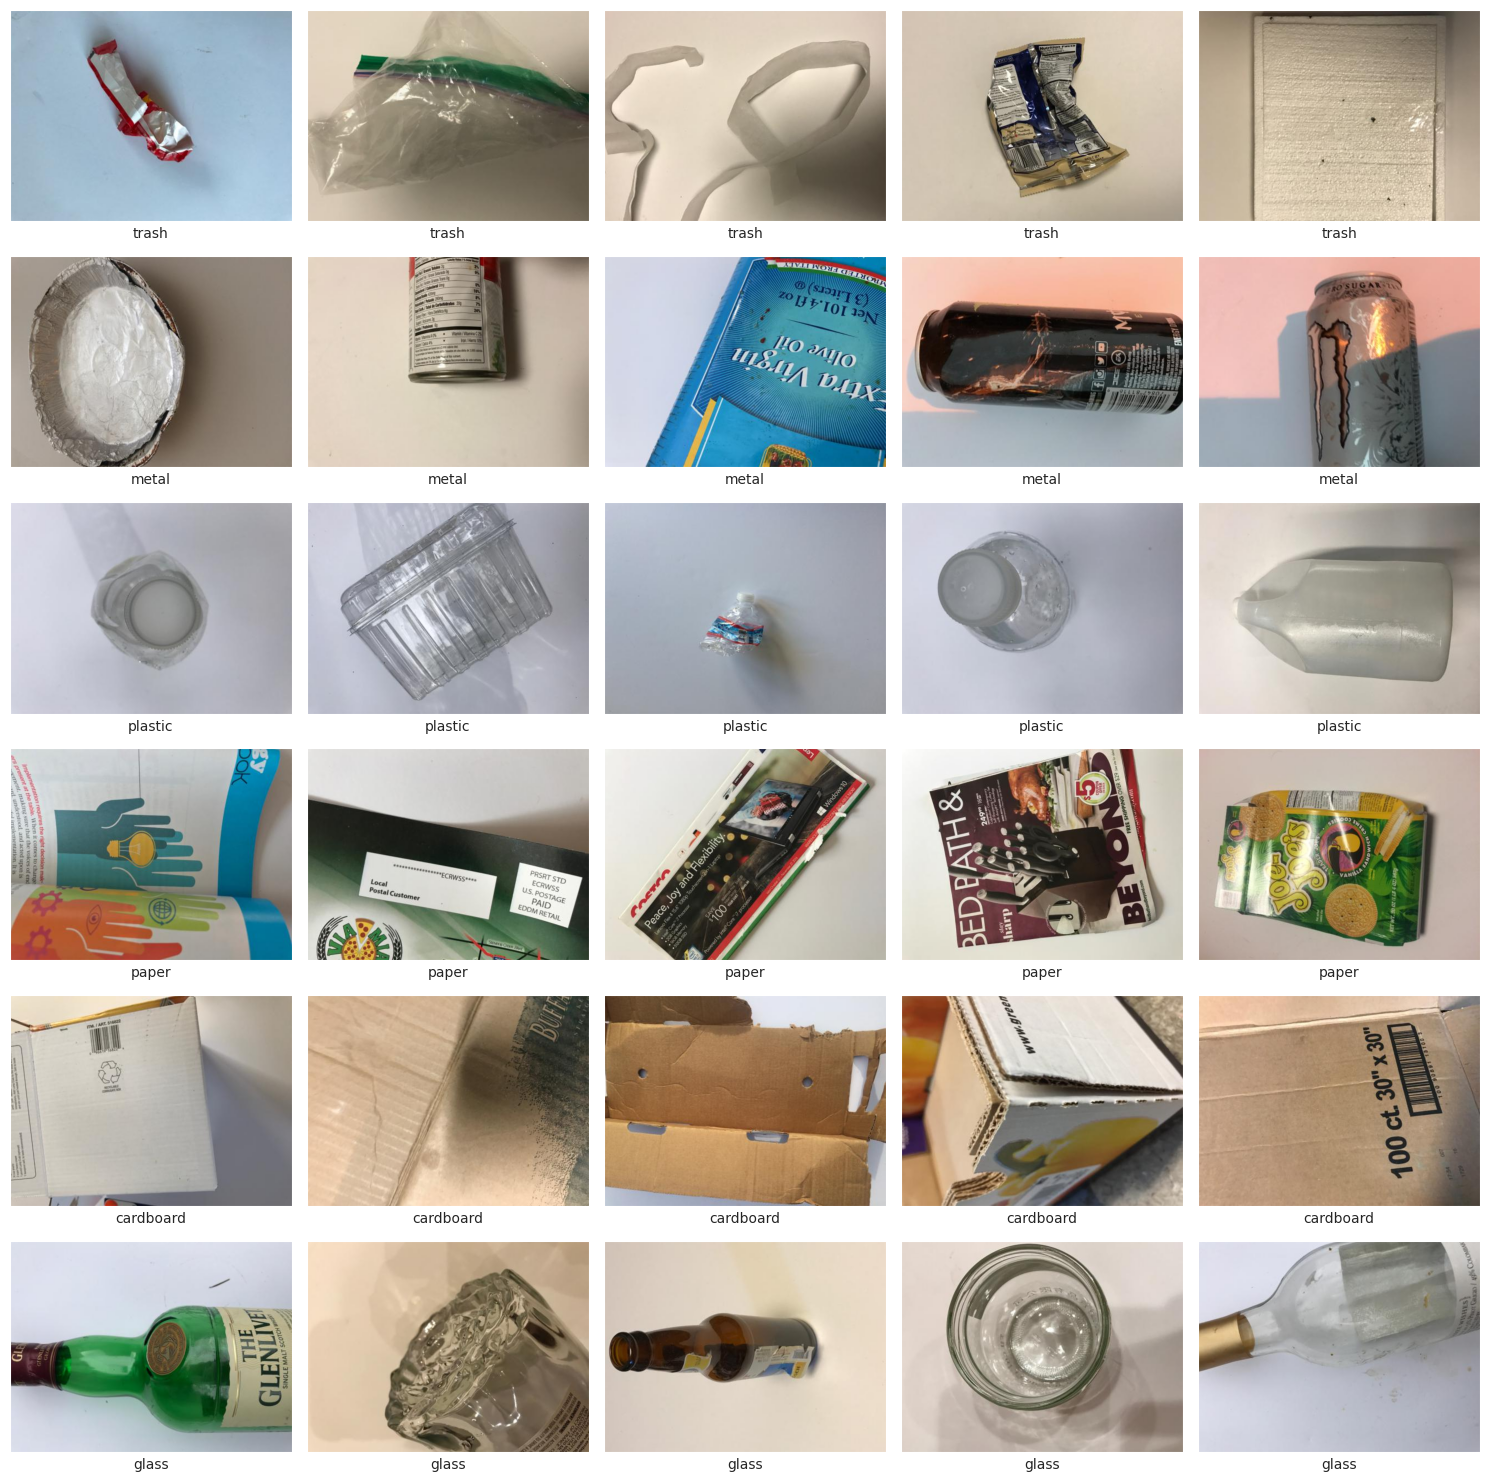

In [43]:
#Checking Dataset
lung_image = {}

# Tentukan path sumber train
path = "train"
# path_sub = os.path.join(path, "Train") # Remove or comment out this line as "Train" directory doesn't exist
for i in os.listdir(path): # Use path directly to iterate through the classes
    lung_image[i] = os.listdir(os.path.join(path, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = "TrashType_Image_Dataset" # This path should also be updated to 'train'

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

import numpy as np # Import numpy for np.random.choice

for i, class_name in enumerate(os.listdir(path_sub)): # Update loop to use 'path' instead of 'path_sub'
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)# Update path_sub to 'path'
        img = Image.open(img_path).convert('RGB')
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

### Data Preprocessing

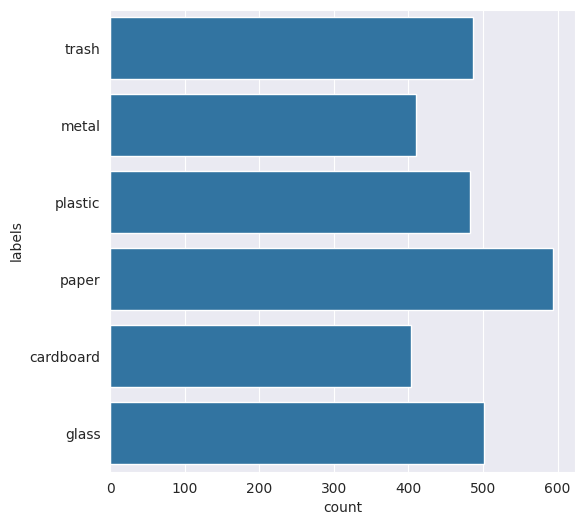

In [42]:
# Definisikan path sumber
lung_path = "TrashType_Image_Dataset"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

data diatas menunjukan ketidak seimbangan data pada class trash

In [44]:
#MELAKUKAN AUGMENTASI DATA PADA CLASS TRASH
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

all_augmentation = {
    "shear": sheared,
    "blur": blur_image
}

images_path="TrashType_Image_Dataset/trash/" # Path untuk gambar asli
augmented_path="TrashType_Image_Dataset/trash/" # Path untuk gambar yang sudah diaugmentasi
images=[] # Penyimpanan gambar yang telah melalui pra-pemrosesan

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi, jumlahnya disesuaikan sesuai kebutuhan
# Variabel untuk melakukan iterasi sampai jumlah gambar yang ditentukan dalam images_to_generate
images_to_generate= 350
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(all_augmentation)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(all_augmentation)) # Secara acak memilih dan memanggil metode
            transformed_image = all_augmentation[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

<ipython-input-45-21dbd9040f0a>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_count.index, y=class_count.values, palette = "dark:#5A9_r")


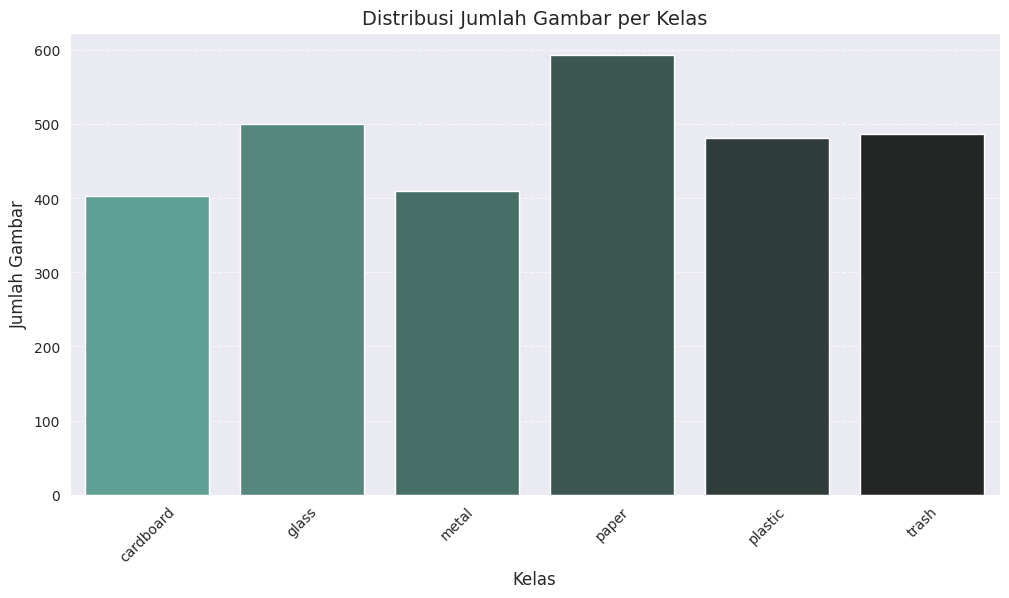

In [45]:
# menampilkah jumlah data dari setippa kelasnya after augmentasi data
mypath= 'TrashType_Image_Dataset'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
class_count= df.groupby(['labels']).size()


# Visualisasi dengan seaborn
plt.figure(figsize=(12,6))
sns.barplot(x=class_count.index, y=class_count.values, palette = "dark:#5A9_r")

# Menambahkan label dan judul
plt.xlabel("Kelas", fontsize=12)
plt.ylabel("Jumlah Gambar", fontsize=12)
plt.title("Distribusi Jumlah Gambar per Kelas", fontsize=14)
plt.xticks(rotation=45)  # Memutar label agar tidak bertumpuk
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menampilkan grafik
plt.show()

In [63]:
# IMAGE DATA GENERATOR
datagen = ImageDataGenerator(
                              rescale=1/255.,
                              rotation_range=20,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(train_dir,
                                              batch_size=32,
                                              target_size=(224,224),
                                              class_mode='categorical',
                                              subset='training')


validation_generator = val_test_datagen.flow_from_directory(val_dir,
                                                            batch_size=1,
                                                            target_size=(224,224),
                                                            class_mode='categorical')


test_generator = val_test_datagen.flow_from_directory(test_dir,
                                                      batch_size=1,
                                                      target_size=(224,224),
                                                      class_mode='categorical',
                                                      shuffle=False)

Found 1766 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
Found 384 images belonging to 6 classes.


#### Split Dataset

In [68]:
split_data

<function __main__.split_data(source_dir, train_dir, val_dir, test_dir, train_size=0.7, val_size=0.2, test_size=0.1)>

## Modelling

In [65]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False


In [67]:
# Define CNN Model
model = Sequential([
       # First convolutional block
       Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
       MaxPooling2D((2, 2)),
       # Second convolutional block
       Conv2D(64, (3, 3), padding='same', activation='relu'),
       MaxPooling2D((2, 2)),
       # Third convolutional block
       Conv2D(128, (3, 3), padding='same', activation='relu'),
       MaxPooling2D((2, 2)),
       # Flatten the output of the last Conv2D layer
       Flatten(),
       # Fully connected layers
       Dropout(0.3),
       Dense(128, activation='relu'),
       Dropout(0.3),
       Dense(64, activation='relu'),
       Dropout(0.2),
       # Output layer for 5-class classification
       Dense(6, activation='softmax') # Changed the output layer to 6 neurons
    ])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 265s 5s/step - accuracy: 0.2288 - loss: 1.8489 - val_accuracy: 0.3899 - val_loss: 1.5163 - learning_rate: 5.0000e-04
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 253s 5s/step - accuracy: 0.3482 - loss: 1.5536 - val_accuracy: 0.3607 - val_loss: 1.4940 - learning_rate: 5.0000e-04
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 253s 5s/step - accuracy: 0.3926 - loss: 1.4902 - val_accuracy: 0.3979 - val_loss: 1.4546 - learning_rate: 5.0000e-04
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 251s 4s/step - accuracy: 0.3881 - loss: 1.4755 - val_accuracy: 0.4695 - val_loss: 1.3673 - learning_rate: 5.0000e-04
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 245s 4s/step - accuracy: 0.4378 - loss: 1.3856 - val_accuracy: 0.4748 - val_loss: 1.3397 - learning_rate: 5.0000e-04
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 247s 4s/step - accuracy: 0.4447 - loss: 1.3726 - val_accuracy: 0.4483 - val_loss: 1.4213 - learning_rate: 5.0000e-04
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 241s 4s/step - accuracy: 0.4583 

## Evaluasi dan Visualisasi

## Konversi Model

## Inference (Optional)